# Parameter Tuning the LGN Inputs

In the following we try to find more appropiate values using a grid-search on the **syn_weight** parameter. We will run the simulation four times in a row, each time increasing/decreasing the **syn_weight** by some factor depending on the edge's target cell_line. Each iteration we'll record the updated **syn_weight** and the cell-line's mean firing-rate so we can plot the results at the end. 


Once we have a better idea of different feed-forward **syn_weight** values are best for different cell-models it will be trivial to update the *lgn_l4_edge_types.csv* **syn_weight** values.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nest


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: UNKNOWN
 Built: Mar  1 2022 09:35:52

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



Based on these initial results, it looks like we will want to increase the firing rates for most of the populations, the best way of doing that is to increase the synaptic strengths of LGN --> L4 connections.

This can be done by rebuilding the network, but for larger models this can be time consuming, plus we will probably need to adjust weights multiple times. Instead the BMTK has a way of adjusting the synaptic weights dynamically during simulation-time. In the SONATA edges file for LGN --> L4 connections we include an optional column called **weight_function**:

In [4]:
edge_types_df = pd.read_csv('network/lgn_l4_edge_types.csv', sep=' ')
edge_types_df.style.applymap(lambda *_: 'background-color: yellow', subset=pd.IndexSlice[:, 'weight_function'])

,edge_type_id,target_query,source_query,dynamics_params,syn_weight,model_template,delay,weight_function
0,100,model_name=='Sst_501282204',*,i2e.json,0.000000,static_synapse,1.700000,set_syn_weight
1,101,model_name=='Rorb_314642645',*,e2e.json,0.518667,static_synapse,1.700000,set_syn_weight
2,102,model_name=='Scnn1a_517982558',*,e2e.json,0.517374,static_synapse,1.700000,set_syn_weight
3,103,model_name=='Htr3a_474626527',*,i2e.json,0.000000,static_synapse,1.700000,set_syn_weight
4,104,model_name=='other_483018019',*,e2e.json,0.515249,static_synapse,1.700000,set_syn_weight
5,105,model_name=='Pvalb_478958894',*,i2e.json,1.791676,static_synapse,1.700000,set_syn_weight


*set_syn_weight* is a built-in function that is used by bmtk to calculate synaptic weights for pairs of source/target cells. *set_syn_weight* is a function that takes in a table of edge and cell properties and returns a list of updated synaptic-weight, by default simply by returning the **syn_weigth** times the number of actualy synapses (which defaults to 1 if not explicity stated).

```python
def default_weight_fnc(edge_props, source_nodes, target_nodes):
    return edge_props['syn_weight']*edge_props.nsyns
```

However with bmtk we can override this behavior

In [ ]:
from bmtk.simulator import pointnet
from bmtk.simulator.pointnet.pyfunction_cache import synaptic_weight


@synaptic_weight
def set_syn_weight(edge_props, source_nodes, target_nodes):
    src_location = source_nodes['location'].unique()[0]
    if src_location != 'LGN':
        return edge_props['syn_weight'].values*edge_props.nsyns
    
    trg_types = target_nodes['cell_line'].values
    syn_weights = edge_props['syn_weight'].values
    nsyns = edge_props.nsyns
    assert(len(trg_types) == len(syn_weights) == len(nsyns))
    
    update_fnc = np.vectorize(lambda i: 2 if i != 'i4Pvalb' else 1)
    update_factor = update_fnc(trg_types)
    updated_syn_weights = update_factor*syn_weights*nsyns
    return updated_syn_weights


configure = pointnet.Config.from_json('config.simulation_pointnet.feedforward.json')
configure.build_env()

graph = pointnet.PointNetwork.from_config(configure)
sim = pointnet.PointSimulator.from_config(configure, graph)
sim.run()

In [2]:
from bmtk.analyzer.spike_trains import spike_statistics
from bmtk.simulator.pointnet.pyfunction_cache import synaptic_weight
from bmtk.simulator import pointnet

grid_search = {
    'e4Rorb': [0.5, 1.0, 1.5, 2.0],
    'e4Scnn1a': [1.0, 1.25, 1.75, 2.0],
    'e4other': [0.5, 1.0, 1.5, 2.0],
    'i4Htr3a': [1.0, 2.0, 2.5, 3.0],
    'i4Pvalb': [0.01, 0.1, 0.2, 0.5],
    'i4Sst': [1.0, 2.0, 2.5, 3.0]
}

# Keeps track of current iteration, plus each iterations weights and firing-rates for graphing later
current_itr = 0
weights_table = {cell_line: [] for cell_line in grid_search.keys()}
fr_table = {cell_line: [] for cell_line in grid_search.keys()}


@synaptic_weight
def set_syn_weight(edge_props, source_nodes, target_nodes):
    src_location = source_nodes['location'].unique()[0]
    if src_location != 'LGN':
        return edge_props['syn_weight'].values*edge_props.nsyns
    
    target_type = target_nodes['cell_line'].unique()[0]
    old_syn_weight = edge_props['syn_weight'].unique()[0]
    new_syn_weight = old_syn_weight*grid_search[target_type][current_itr]
    
    # Save the updated weights at each iteration
    weights_table[target_type].append(new_syn_weight)
    
    # return new weights
    return new_syn_weight*edge_props.nsyns
    

for i in range(4):
    current_itr = i
    
    print('>> Running iteration {}'.format(i+1))
    configure = pointnet.Config.from_json('config.simulation_pointnet.feedforward.json')
    configure.build_env()

    graph = pointnet.PointNetwork.from_config(configure)
    sim = pointnet.PointSimulator.from_config(configure, graph)
    sim.run()

    spike_stats_df = spike_statistics('output/spikes.h5', simulation=sim, group_by='cell_line', populations='l4')
    for cell_line, fr in spike_stats_df['firing_rate']['mean'].items():
        fr_table[cell_line].append(fr)


>> Running iteration 1
2022-06-15 08:13:56,681 [INFO] Created log file
2022-06-15 08:13:56,711 [INFO] Batch processing nodes for l4/0.
2022-06-15 08:13:56,790 [INFO] Batch processing nodes for lgn/0.
2022-06-15 08:13:56,800 [INFO] Batch processing nodes for bkg/0.
2022-06-15 08:13:56,869 [INFO] Setting up output directory
2022-06-15 08:13:56,870 [INFO] Building cells.
2022-06-15 08:13:56,952 [INFO] Building recurrent connections
2022-06-15 08:13:56,952 [INFO] Build virtual cell stimulations for lgn_spikes
2022-06-15 08:14:09,577 [INFO] Build virtual cell stimulations for bkg_spikes
2022-06-15 08:14:09,607 [INFO] Network created.
2022-06-15 08:14:09,656 [INFO] Starting Simulation
2022-06-15 08:14:16,109 [INFO] Simulation finished, finalizing results.
2022-06-15 08:14:16,235 [INFO] Done.
>> Running iteration 2
2022-06-15 08:14:17,187 [INFO] Created log file
2022-06-15 08:14:17,207 [INFO] Batch processing nodes for l4/0.
2022-06-15 08:14:17,281 [INFO] Batch processing nodes for lgn/0.
202

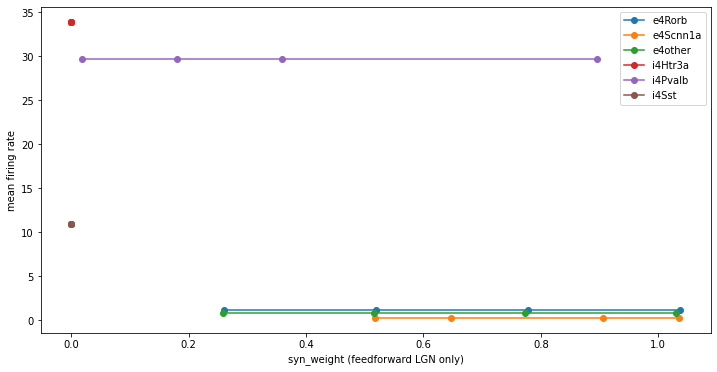

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
for cell_line, weights in weights_table.items():
    firing_rates = fr_table[cell_line]
    ax.plot(weights, firing_rates, '-o', label=cell_line)

ax.set_xlabel('syn_weight (feedforward LGN only)')
ax.set_ylabel('mean firing rate')
ax.legend()    
plt.show()